In [1]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.device_count() > 0 else "No GPU detected")


Torch version: 2.5.0
CUDA available: True
CUDA version: 11.8
Number of GPUs: 1
GPU name: NVIDIA GeForce RTX 4090


## Network Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Output channels: 16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # Output channels: 32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Output channels: 64
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # Output channels: 64
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # Output channels: 64
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # Output channels: 64
        self.conv7 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # Output channels: 64
        self.conv8 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Output channels: 128
        self.conv9 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # Output channels: 256
        self.fc0 = nn.Linear(64, 64)    # the FCL for x1
        self.fc1 = nn.Linear(2*2*256, 64)  # Fully connected layer
        self.fc2 = nn.Linear(64, 3)         # Output layer

        # Define trainable tensors
        self.Wk = nn.Parameter(torch.randn(64, 4, 4) * 0.001)   # Tensor for custom computation
        self.Vk = nn.Parameter(torch.randn(64, 4) * 0.001)      # Tensor for custom computation

    def forward(self, x, x1):
        # Reshape x to 4D and print initial size
        x = x.view(-1, 1, 64, 64)  # Reshape x to [batch_size, 1, 64, 64]
        # print("Initial size of x:", x.size()) # Should be [batch_size, 1, 64, 64]

        # Handling custom operations
        DT_Wk_D = torch.einsum('bi,kij,bj->bk', x1, self.Wk, x1) + torch.einsum('ij,bj->bi', self.Vk, x1) # [batch_size, 64]
        DT_Wk_D = self.fc0(DT_Wk_D).unsqueeze(2).unsqueeze(3).expand(-1, -1, 8, 8) # [batch_size, 64, 8, 8]

        # First convolution and pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)#[batch_size, 16, 32, 32]

        # Second convolution and pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)#  [batch_size, 32, 16, 16]

        # Third convolution and pooling
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2) #  [batch_size, 64, 8, 8]
        
        # x = torch.cat((x, DT_Wk_D), dim=1)
        x = x + DT_Wk_D

        # Additional convolutions without pooling
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv9(x))
        x = F.max_pool2d(x, 2) #[batch_size, 256, 2, 2]

        # Flatten for FC layers
        x = torch.flatten(x, 1) # [batch_size, 1024]

        # Continue with the final layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # [batch_size, 1]

        return x

model = CustomModel()
optimizer = Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()  # Assuming MSE loss as in TensorFlow

## Data handling

In [3]:
import h5py
import numpy as np

# Adjust file paths and set up the dataset and data loader
file_path = r"C:\Users\evod\work\ai13\pytorch\data\train_test_split.h5"
with h5py.File(file_path, "r") as f:
    neff_train = np.array(f['neff_train'])
    weight_train = np.array(f['weight_train'])
    params_train = np.array(f['params_train'])
    pattern_train = np.array(f['pattern_train'])
    
    neff_test = np.array(f['neff_test'])
    weight_test = np.array(f['weight_test'])
    params_test = np.array(f['params_test'])
    pattern_test = np.array(f['pattern_test'])



In [4]:
# process the data, remove all modes with n_eff=0
from tqdm import tqdm

# Result arrays initialized with zeros or some invalid value
modified_neff_train = np.zeros_like(neff_train)
modified_weight_train = np.zeros_like(weight_train)

modified_neff_test = np.zeros_like(neff_test)
modified_weight_test = np.zeros_like(weight_test)

for i in tqdm(range(neff_train.shape[0]), desc="Processing Training Data Rows"):
    # Filter out zeros and get the remaining valid entries
    valid_indices = neff_train[i] != 0
    valid_values_neff = neff_train[i][valid_indices]
    valid_values_weight = weight_train[i][valid_indices]

    # Place valid entries at the start of the row in the result arrays
    modified_neff_train[i, :len(valid_values_neff)] = valid_values_neff
    modified_weight_train[i, :len(valid_values_weight)] = valid_values_weight

for i in tqdm(range(neff_test.shape[0]), desc="Processing Test Data Rows"):
    # Filter out zeros and get the remaining valid entries
    valid_indices = neff_test[i] != 0
    valid_values_neff = neff_test[i][valid_indices]
    valid_values_weight = weight_test[i][valid_indices]

    # Place valid entries at the start of the row in the result arrays
    modified_neff_test[i, :len(valid_values_neff)] = valid_values_neff
    modified_weight_test[i, :len(valid_values_weight)] = valid_values_weight

Processing Test Data Rows: 100%|███████████████████████████████████████████| 477427/477427 [00:01<00:00, 238795.28it/s]


In [5]:
# dataframe to matrix
xs = pattern_train.reshape([-1,64*64])
x1s = params_train
ys = modified_weight_train[:,0:3]/100

xs1 = pattern_test.reshape([-1,64*64])
x1s1 = params_test
ys1 = modified_weight_test[:,0:3]/100


batch_size = 256
n_batch = modified_neff_train.shape[0]//batch_size
n_batch1 = modified_neff_test.shape[0]//batch_size
# testbatch_size = data_test.shape[0]//n_batch

# Convert and cache tensors before training starts
xs = torch.tensor(xs, dtype=torch.float32)
x1s = torch.tensor(x1s, dtype=torch.float32)
ys = torch.tensor(ys, dtype=torch.float32)

xs1 = torch.tensor(xs1, dtype=torch.float32)
x1s1 = torch.tensor(x1s1, dtype=torch.float32)
ys1 = torch.tensor(ys1, dtype=torch.float32)

## Training loop

In [24]:
import torch
import torch.optim as optim
from torch.autograd import Variable

# Assuming your model is defined as `model`
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()  # Adjust this if your loss is different

# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Main training loop
for i in range(10000):
    train_losses=[] 
    test_losses=[]

    model.train()
    for batch in range(n_batch):
        
        batch_xs = xs[batch*batch_size:(batch+1)*batch_size,:]
        batch_x1s = x1s[batch*batch_size:(batch+1)*batch_size,:]
        batch_ys = ys[batch*batch_size:(batch+1)*batch_size,:]
        
        optimizer.zero_grad()
        outputs = model(batch_xs.to(device), batch_x1s.to(device))  # Adjust if your model takes two inputs differently
        loss = criterion(outputs, batch_ys.to(device))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    for batch in range(n_batch1):
        
        batch_xs1 = xs1[batch*batch_size:(batch+1)*batch_size,:]
        batch_x1s1 = x1s1[batch*batch_size:(batch+1)*batch_size,:]
        batch_ys1 = ys1[batch*batch_size:(batch+1)*batch_size,:]
        
        outputs = model(batch_xs1.to(device), batch_x1s1.to(device))  # Adjust if your model takes two inputs differently
        loss = criterion(outputs, batch_ys1.to(device))
        test_losses.append(loss.item())
    
    print(f"After {i} iteration,")
    print(f"Training loss: {np.mean(train_losses)}, Test loss: {np.mean(test_losses)}")

After 0 iteration,
Training loss: 0.018177748898566933, Test loss: 0.01213882790562145
After 1 iteration,
Training loss: 0.019706179242635926, Test loss: 0.015536552974844327
After 2 iteration,
Training loss: 0.01930588801741177, Test loss: 0.012734600837575272
After 3 iteration,
Training loss: 0.02052070570767604, Test loss: 0.014496320691469321
After 4 iteration,
Training loss: 0.01853931843451051, Test loss: 0.012385632423708983
After 5 iteration,
Training loss: 0.01739010612528075, Test loss: 0.011923580857387508
After 6 iteration,
Training loss: 0.017089846784611118, Test loss: 0.011715381133695864
After 7 iteration,
Training loss: 0.016729076993727676, Test loss: 0.011541187492785815
After 8 iteration,
Training loss: 0.016821405297143963, Test loss: 0.011592059132399222
After 9 iteration,
Training loss: 0.0166159486108601, Test loss: 0.011460141084944357
After 10 iteration,
Training loss: 0.01640748964673774, Test loss: 0.011276950237921803
After 11 iteration,
Training loss: 0.01

After 93 iteration,
Training loss: 0.01814767014439888, Test loss: 0.015637380296320457
After 94 iteration,
Training loss: 0.01869048872091205, Test loss: 0.012307479031171147
After 95 iteration,
Training loss: 0.017241251244164972, Test loss: 0.011744341359607667
After 96 iteration,
Training loss: 0.01681361289975736, Test loss: 0.011491930228408203
After 97 iteration,
Training loss: 0.016499196277512656, Test loss: 0.01133615775655879
After 98 iteration,
Training loss: 0.016368725900301744, Test loss: 0.011312321744021827
After 99 iteration,
Training loss: 0.01708564933303164, Test loss: 0.011697795362483566
After 100 iteration,
Training loss: 0.016937010091941585, Test loss: 0.01235616152837289
After 101 iteration,
Training loss: 0.018461879579370902, Test loss: 0.012895177110985657
After 102 iteration,
Training loss: 0.01686097019391832, Test loss: 0.011412379754267038
After 103 iteration,
Training loss: 0.017756272080125146, Test loss: 0.011721094693766722
After 104 iteration,
Tra

After 185 iteration,
Training loss: 0.01811690639257748, Test loss: 0.012293023061154155
After 186 iteration,
Training loss: 0.017246385718308607, Test loss: 0.011746505999342087
After 187 iteration,
Training loss: 0.01684660173901636, Test loss: 0.01149156151285451
After 188 iteration,
Training loss: 0.016665338856287744, Test loss: 0.011355112316641484
After 189 iteration,
Training loss: 0.01633872181849571, Test loss: 0.011333059848040391
After 190 iteration,
Training loss: 0.017181273988968005, Test loss: 0.012258556121715461
After 191 iteration,
Training loss: 0.016812347152913163, Test loss: 0.011420272205768417
After 192 iteration,
Training loss: 0.016775758384864576, Test loss: 0.011634329488414016
After 193 iteration,
Training loss: 0.017569893961078806, Test loss: 0.01190659789183145
After 194 iteration,
Training loss: 0.016158610884159277, Test loss: 0.01430513911212039
After 195 iteration,
Training loss: 0.017171323407716214, Test loss: 0.011483804567975828
After 196 iterat

After 277 iteration,
Training loss: 0.015439989880477388, Test loss: 0.011761162459401637
After 278 iteration,
Training loss: 0.017863183016789266, Test loss: 0.013214337743809767
After 279 iteration,
Training loss: 0.01644449238831289, Test loss: 0.011460413581548286
After 280 iteration,
Training loss: 0.015812868700398917, Test loss: 0.012322978300438162
After 281 iteration,
Training loss: 0.01719045871504848, Test loss: 0.015402233239454157
After 282 iteration,
Training loss: 0.02779759676356217, Test loss: 0.014288972939070825
After 283 iteration,
Training loss: 0.01802507858048937, Test loss: 0.01199565197355134
After 284 iteration,
Training loss: 0.017172792895982385, Test loss: 0.01153289430658333
After 285 iteration,
Training loss: 0.016705666443855734, Test loss: 0.011652417815452273
After 286 iteration,
Training loss: 0.017754419211668957, Test loss: 0.012617744568359634
After 287 iteration,
Training loss: 0.01296140867556415, Test loss: 0.012079300135054302
After 288 iterati

After 369 iteration,
Training loss: 0.0167315217313791, Test loss: 0.01164288211827738
After 370 iteration,
Training loss: 0.017982143551225523, Test loss: 0.014011367073891157
After 371 iteration,
Training loss: 0.018834787066518605, Test loss: 0.01263246646869424
After 372 iteration,
Training loss: 0.017431813164418716, Test loss: 0.011962959565728895
After 373 iteration,
Training loss: 0.01527055581251189, Test loss: 0.011846761216080744
After 374 iteration,
Training loss: 0.015362378909498525, Test loss: 0.014270229563376839
After 375 iteration,
Training loss: 0.020620314018814555, Test loss: 0.014170370718949903
After 376 iteration,
Training loss: 0.018453697426269445, Test loss: 0.012727767105045421
After 377 iteration,
Training loss: 0.017580459486107508, Test loss: 0.012478990738241146
After 378 iteration,
Training loss: 0.017165998237569702, Test loss: 0.011867702333056748
After 379 iteration,
Training loss: 0.016842621737130893, Test loss: 0.011582620519357274
After 380 itera

After 461 iteration,
Training loss: 0.017641850472705098, Test loss: 0.011806103582628862
After 462 iteration,
Training loss: 0.019351365148098175, Test loss: 0.013267832997683715
After 463 iteration,
Training loss: 0.017547117023549202, Test loss: 0.01346075738659788
After 464 iteration,
Training loss: 0.023732293078738368, Test loss: 0.013739491139749432
After 465 iteration,
Training loss: 0.012859008305046174, Test loss: 0.012413380349798392
After 466 iteration,
Training loss: 0.01440716260978646, Test loss: 0.014058264571965509
After 467 iteration,
Training loss: 0.01726323216700838, Test loss: 0.012385602468247985
After 468 iteration,
Training loss: 0.01569343189635256, Test loss: 0.012140261873082247
After 469 iteration,
Training loss: 0.016136977826137034, Test loss: 0.012096563644548319
After 470 iteration,
Training loss: 0.01751100330584015, Test loss: 0.011744927237951496
After 471 iteration,
Training loss: 0.019245430770632153, Test loss: 0.01482654512633046
After 472 iterat

After 553 iteration,
Training loss: 0.014665947951407689, Test loss: 0.013709853420882434
After 554 iteration,
Training loss: 0.015916949900805135, Test loss: 0.014785272039297184
After 555 iteration,
Training loss: 0.016000965888515864, Test loss: 0.013057956656654938
After 556 iteration,
Training loss: 0.017648446890460235, Test loss: 0.01183289749677245
After 557 iteration,
Training loss: 0.016877463534264607, Test loss: 0.012281638011036544
After 558 iteration,
Training loss: 0.017074192922883005, Test loss: 0.011878872022823162
After 559 iteration,
Training loss: 0.016868531349646127, Test loss: 0.011708449483139625
After 560 iteration,
Training loss: 0.017314432736082075, Test loss: 0.011547793058779435
After 561 iteration,
Training loss: 0.0159377943858923, Test loss: 0.01230055965918372
After 562 iteration,
Training loss: 0.016669411073609846, Test loss: 0.012595695254214051
After 563 iteration,
Training loss: 0.014305926111227763, Test loss: 0.012105388680394027
After 564 iter

After 645 iteration,
Training loss: 0.014210221910422403, Test loss: 0.012724861539995233
After 646 iteration,
Training loss: 0.01686788979039954, Test loss: 0.01336344449716928
After 647 iteration,
Training loss: 0.013777985983709924, Test loss: 0.011962335074346417
After 648 iteration,
Training loss: 0.013997050351168942, Test loss: 0.013385320003489192
After 649 iteration,
Training loss: 0.01162443513084281, Test loss: 0.013240953241230105
After 650 iteration,
Training loss: 0.011056639110681053, Test loss: 0.012519998633294754
After 651 iteration,
Training loss: 0.012456495074942276, Test loss: 0.013409429620636643
After 652 iteration,
Training loss: 0.012363922936998957, Test loss: 0.012555374039932605
After 653 iteration,
Training loss: 0.011684516320226384, Test loss: 0.012957777139603844
After 654 iteration,
Training loss: 0.009531883864863248, Test loss: 0.016848105032025943
After 655 iteration,
Training loss: 0.01060603747807462, Test loss: 0.012226268193057974
After 656 iter

After 737 iteration,
Training loss: 0.012342784722650072, Test loss: 0.01226492881547068
After 738 iteration,
Training loss: 0.010939579213083465, Test loss: 0.013250819327211798
After 739 iteration,
Training loss: 0.013636427298868882, Test loss: 0.01483603639432225
After 740 iteration,
Training loss: 0.022591027043763246, Test loss: 0.015086936164605371
After 741 iteration,
Training loss: 0.018276568496997065, Test loss: 0.015236975873476733
After 742 iteration,
Training loss: 0.012344658437127839, Test loss: 0.01319719239212013
After 743 iteration,
Training loss: 0.014332150619349032, Test loss: 0.01352194279718089
After 744 iteration,
Training loss: 0.014739053185001337, Test loss: 0.0141996817551893
After 745 iteration,
Training loss: 0.013703739337190315, Test loss: 0.012634916185569257
After 746 iteration,
Training loss: 0.011897960497568107, Test loss: 0.014155233851454096
After 747 iteration,
Training loss: 0.014665737311167193, Test loss: 0.013070383602793252
After 748 iterat

After 829 iteration,
Training loss: 0.01393225257658667, Test loss: 0.013653636980345153
After 830 iteration,
Training loss: 0.012412097259788294, Test loss: 0.012743627942814752
After 831 iteration,
Training loss: 0.010780551130533427, Test loss: 0.014119103845821438
After 832 iteration,
Training loss: 0.012814664801559577, Test loss: 0.013759802534148026
After 833 iteration,
Training loss: 0.01353989610646688, Test loss: 0.013110468453375919
After 834 iteration,
Training loss: 0.011166137488348266, Test loss: 0.014599628035776526
After 835 iteration,
Training loss: 0.014680484857006069, Test loss: 0.01507349700473105
After 836 iteration,
Training loss: 0.01828186190392804, Test loss: 0.012178650163833548
After 837 iteration,
Training loss: 0.01697144667021639, Test loss: 0.011690728846525717
After 838 iteration,
Training loss: 0.017177503109134528, Test loss: 0.013921705815319547
After 839 iteration,
Training loss: 0.01689613846643742, Test loss: 0.012646689397470762
After 840 iterat

After 921 iteration,
Training loss: 0.010289694366709488, Test loss: 0.017005900894476563
After 922 iteration,
Training loss: 0.021367771276121928, Test loss: 0.014058522625262708
After 923 iteration,
Training loss: 0.014034969289353667, Test loss: 0.014907133745533202
After 924 iteration,
Training loss: 0.018342831589014428, Test loss: 0.01468578920761611
After 925 iteration,
Training loss: 0.011784105020399921, Test loss: 0.01335589022062371
After 926 iteration,
Training loss: 0.01786904677435528, Test loss: 0.013129712698372608
After 927 iteration,
Training loss: 0.01859193293945412, Test loss: 0.013159288187004634
After 928 iteration,
Training loss: 0.016143667773636655, Test loss: 0.013625639892990657
After 929 iteration,
Training loss: 0.015732756811623286, Test loss: 0.013933399721406512
After 930 iteration,
Training loss: 0.013006934514089432, Test loss: 0.02449399487966324
After 931 iteration,
Training loss: 0.011472445984204691, Test loss: 0.0385283545900462
After 932 iterati

After 1013 iteration,
Training loss: 0.018409291952854855, Test loss: 0.013065610089451235
After 1014 iteration,
Training loss: 0.011844325318360598, Test loss: 0.012272080398427499
After 1015 iteration,
Training loss: 0.016758644901142396, Test loss: 0.014069855153958349
After 1016 iteration,
Training loss: 0.012310412299603744, Test loss: 0.012375235818616262
After 1017 iteration,
Training loss: 0.009454242139904869, Test loss: 0.012342744275813626
After 1018 iteration,
Training loss: 0.009820665619621822, Test loss: 0.012761883873441517
After 1019 iteration,
Training loss: 0.009644679288298296, Test loss: 0.012374400987605616
After 1020 iteration,
Training loss: 0.01564084834209852, Test loss: 0.01228152861398477
After 1021 iteration,
Training loss: 0.012385465767608291, Test loss: 0.014319469839986014
After 1022 iteration,
Training loss: 0.013135740428213034, Test loss: 0.013149887860363925
After 1023 iteration,
Training loss: 0.009568655859069804, Test loss: 0.015094530643283713
A

After 1104 iteration,
Training loss: 0.00961596186964603, Test loss: 0.012010766256099982
After 1105 iteration,
Training loss: 0.012446801987044485, Test loss: 0.01927760136431151
After 1106 iteration,
Training loss: 0.010648675254954724, Test loss: 0.022396362984334138
After 1107 iteration,
Training loss: 0.009076964460800065, Test loss: 0.022804728027656995
After 1108 iteration,
Training loss: 0.011884582383233658, Test loss: 0.012695148358518225
After 1109 iteration,
Training loss: 0.013340747727541812, Test loss: 0.01197395526979902
After 1110 iteration,
Training loss: 0.00860952620622061, Test loss: 0.011866758624366544
After 1111 iteration,
Training loss: 0.00842962432760806, Test loss: 0.011791378616774055
After 1112 iteration,
Training loss: 0.011673721941671726, Test loss: 0.011739971271072526
After 1113 iteration,
Training loss: 0.008647509256150498, Test loss: 0.016589920911483282
After 1114 iteration,
Training loss: 0.009920217627965529, Test loss: 0.011923866069554891
Afte

After 1195 iteration,
Training loss: 0.01455168842370775, Test loss: 0.012264371039560705
After 1196 iteration,
Training loss: 0.014578681627523486, Test loss: 0.01404941712442162
After 1197 iteration,
Training loss: 0.014160741672820536, Test loss: 0.018357116177672113
After 1198 iteration,
Training loss: 0.0154237513575113, Test loss: 0.012125411830830504
After 1199 iteration,
Training loss: 0.015033132540532118, Test loss: 0.019321884813042988
After 1200 iteration,
Training loss: 0.010117578470841448, Test loss: 0.011881047356404092
After 1201 iteration,
Training loss: 0.018012979918756097, Test loss: 0.015268478060791733
After 1202 iteration,
Training loss: 0.011990139425865548, Test loss: 0.01865458083171657
After 1203 iteration,
Training loss: 0.011433062501993588, Test loss: 0.014882911214891765
After 1204 iteration,
Training loss: 0.011301873800668192, Test loss: 0.014616888817629573
After 1205 iteration,
Training loss: 0.01263556084865321, Test loss: 0.012418464409130478
After

KeyboardInterrupt: 

## Saving and loading models

In [25]:
# Save the model
torch.save(model.state_dict(), '250107_weight_3 mode_delete0.pth')

In [26]:
# Load the model
model_loaded = CustomModel()
model_loaded.load_state_dict(torch.load('250107_weight_3 mode_delete0.pth', weights_only=True))
model_loaded.eval()


CustomModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc0): Linear(in_features=64, out_features=64, bias=True)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

## Plot examples

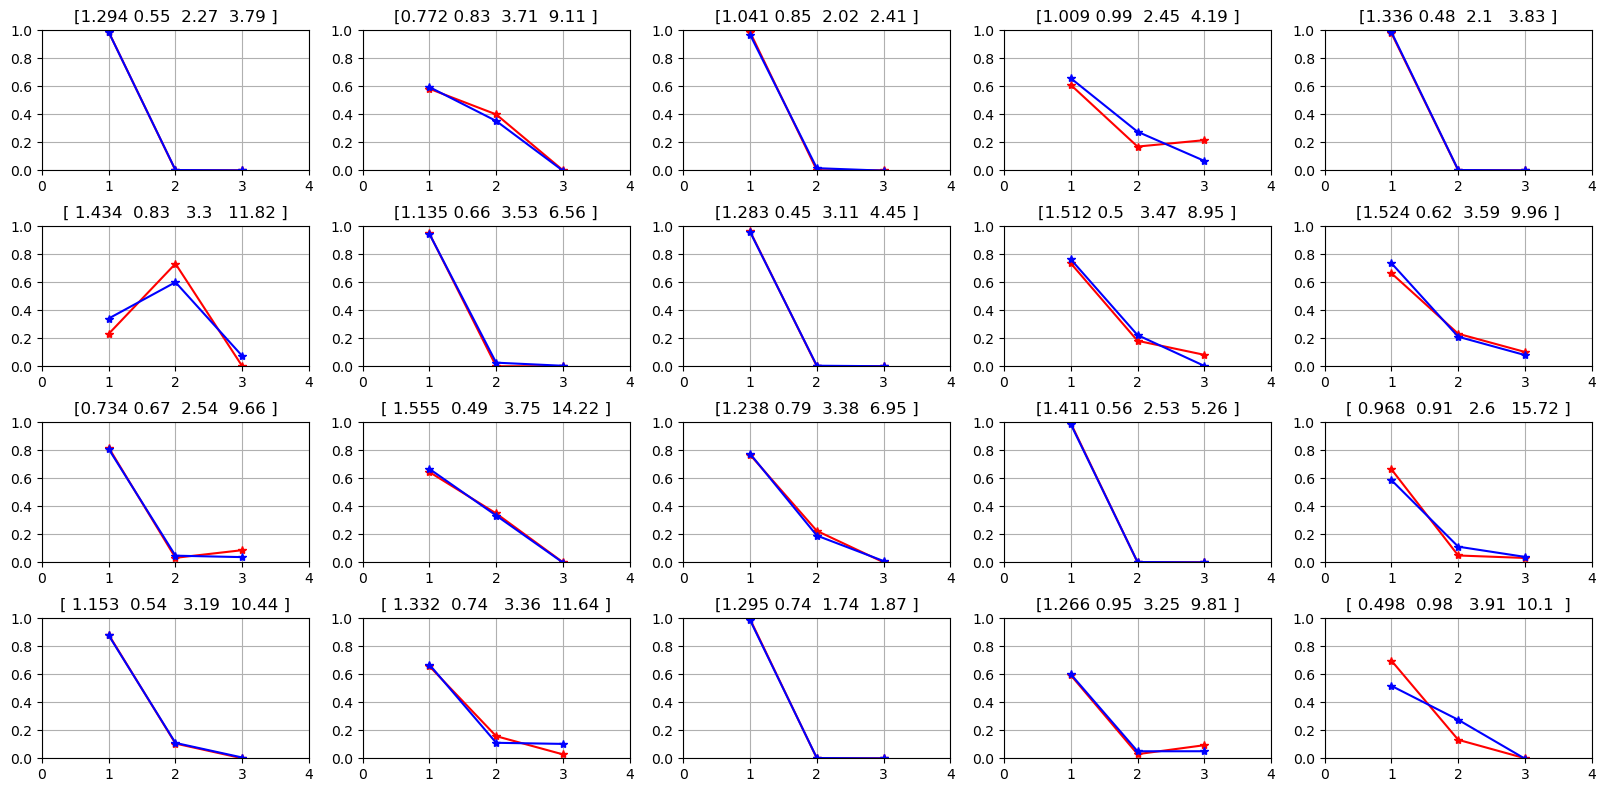

In [27]:
# load real part data (verify the model is working properly)
# [Wavelength, lattice, n_atom, n_substrate]


# plot 20 results from the test set
import matplotlib
import random
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

cases = 20
cols = 5
gs = gridspec.GridSpec(cases // cols + 1, cols)
gs.update(hspace=0.4)
fig1 = plt.figure(figsize = (20,12))
ax = []
test_number = []

model_loaded.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_loaded.to(device)

for i in range(cases):
    number = np.random.randint(0,xs1.shape[0])
    test_number.append(number)
    row = i//cols
    col = i % cols
    
    orig = ys1[number,:].to(device).cpu()
    pred = model_loaded(xs1[number,:].reshape(1,4096).to(device), x1s1[number,:].reshape(1,4).to(device)).cpu().detach().numpy()

    ax.append(fig1.add_subplot(gs[row,col]))
#     yticks = np.arange(-1,1.1,0.5)
#     ax[-1].set_yticks(yticks)
    ax[-1].set_ylim([0,1])
    ax[-1].set_xlim([0,4])

    xaxis = np.linspace(1,3,3)

    ax[-1].plot(xaxis,orig,"r*-")
    ax[-1].plot(xaxis,pred[0],"b*-")
    ax[-1].grid(True)
    ax[-1].set_title(x1s1[number,0:4].detach().cpu().numpy())


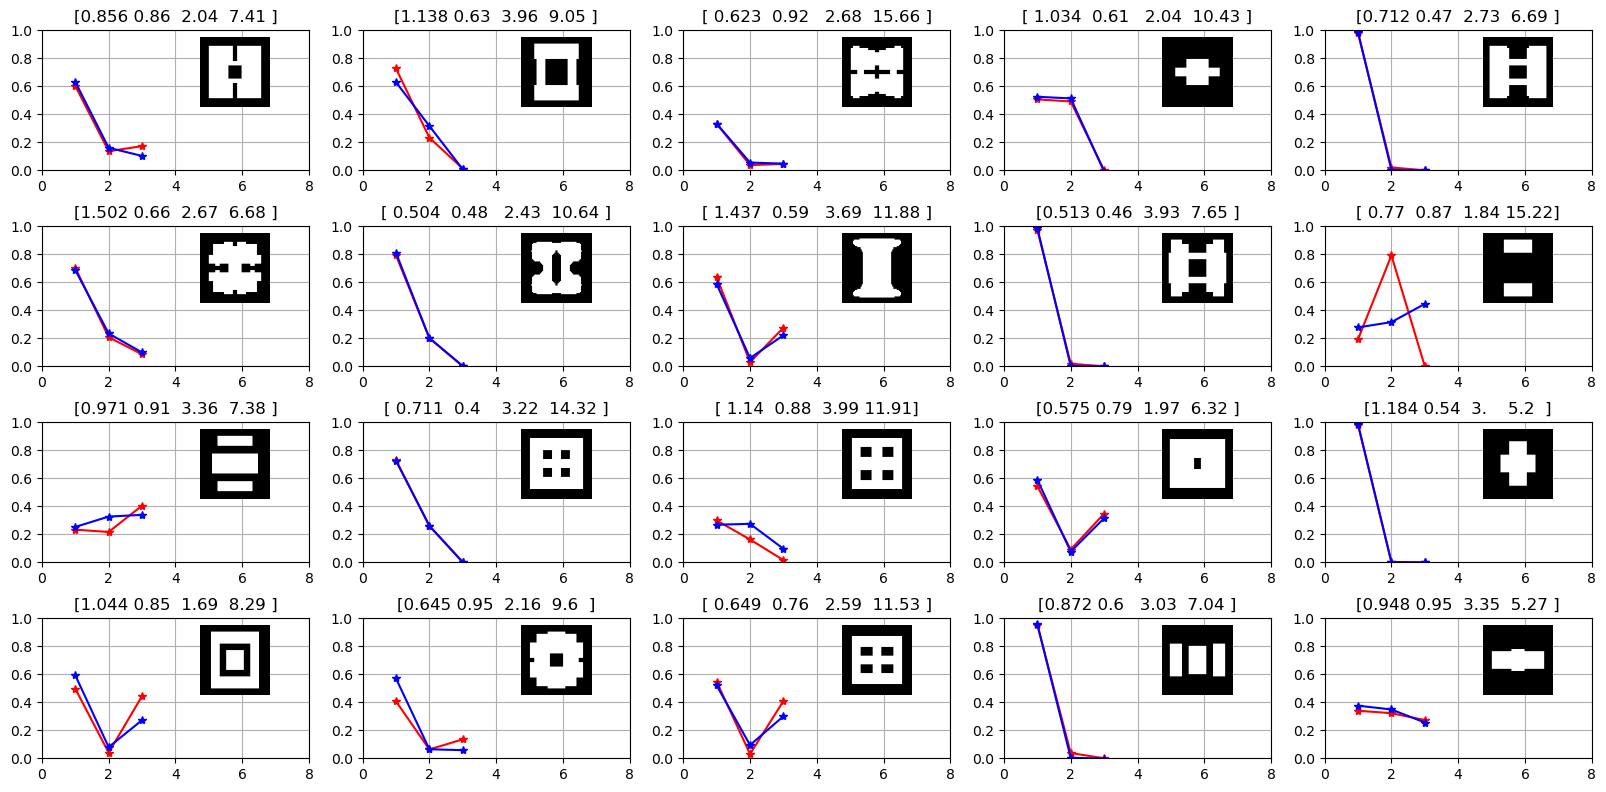

In [29]:
# plot results with 2D inset
# [Wavelength, lattice, n_atom, n_substrate]
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import random
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
cases = 20
cols = 5
gs = gridspec.GridSpec(cases // cols + 1, cols)
gs.update(hspace=0.4)
fig = plt.figure(figsize = (20,12))
ax = []
test_number = []

for i in range(cases):
    number = np.random.randint(0, xs1.shape[0])
    test_number.append(number)
    row = i // cols
    col = i % cols

    # Existing plotting code
    ax = fig.add_subplot(gs[row, col])
    orig = ys1[number,:].to(device).cpu()
    pred = model_loaded(xs1[number, :].reshape(1, 4096).to(device), x1s1[number, :].reshape(1, 4).to(device)).cpu().detach().numpy()

    # Set up the plot for original data and prediction
    ax.plot(xaxis, orig, "r*-")
    ax.plot(xaxis, pred[0], "b*-")
    ax.grid(True)
    ax.set_title(x1s1[number,0:4].detach().cpu().numpy())  # Your existing title setting code
    ax.set_ylim([0,1])
    ax.set_xlim([0,8])
    xaxis = np.linspace(1,3,3)

    # Create an inset axis for the image
    axins = inset_axes(ax, width="50%", height="50%", loc='upper right')
    img_data = xs1[number, :].cpu().numpy().reshape(64, 64)  # Reshape the tensor to 2D
    axins.imshow(img_data, cmap='gray')  # Display the image
    axins.axis('off')  # Turn off axis for inset


In [30]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def scale_pattern_in_binary_image(binary_image, scale_factor):
    # Convert the binary array to an image
    img = Image.fromarray(binary_image.astype('uint8') * 255)

    # Calculate new dimensions according to the scale factor
    new_size = (int(img.width * scale_factor), int(img.height * scale_factor))

    # Resize the image
    resized_img = img.resize(new_size, Image.NEAREST)

    # Create a new blank binary image of the original size
    new_binary_image = Image.new("L", (binary_image.shape[1], binary_image.shape[0]), 0)

    # Calculate the position to paste the resized image back into the center
    top_left_x = (new_binary_image.width - resized_img.width) // 2
    top_left_y = (new_binary_image.height - resized_img.height) // 2

    # Paste the resized image into the center of the blank image
    new_binary_image.paste(resized_img, (top_left_x, top_left_y))

    return np.array(new_binary_image) // 255


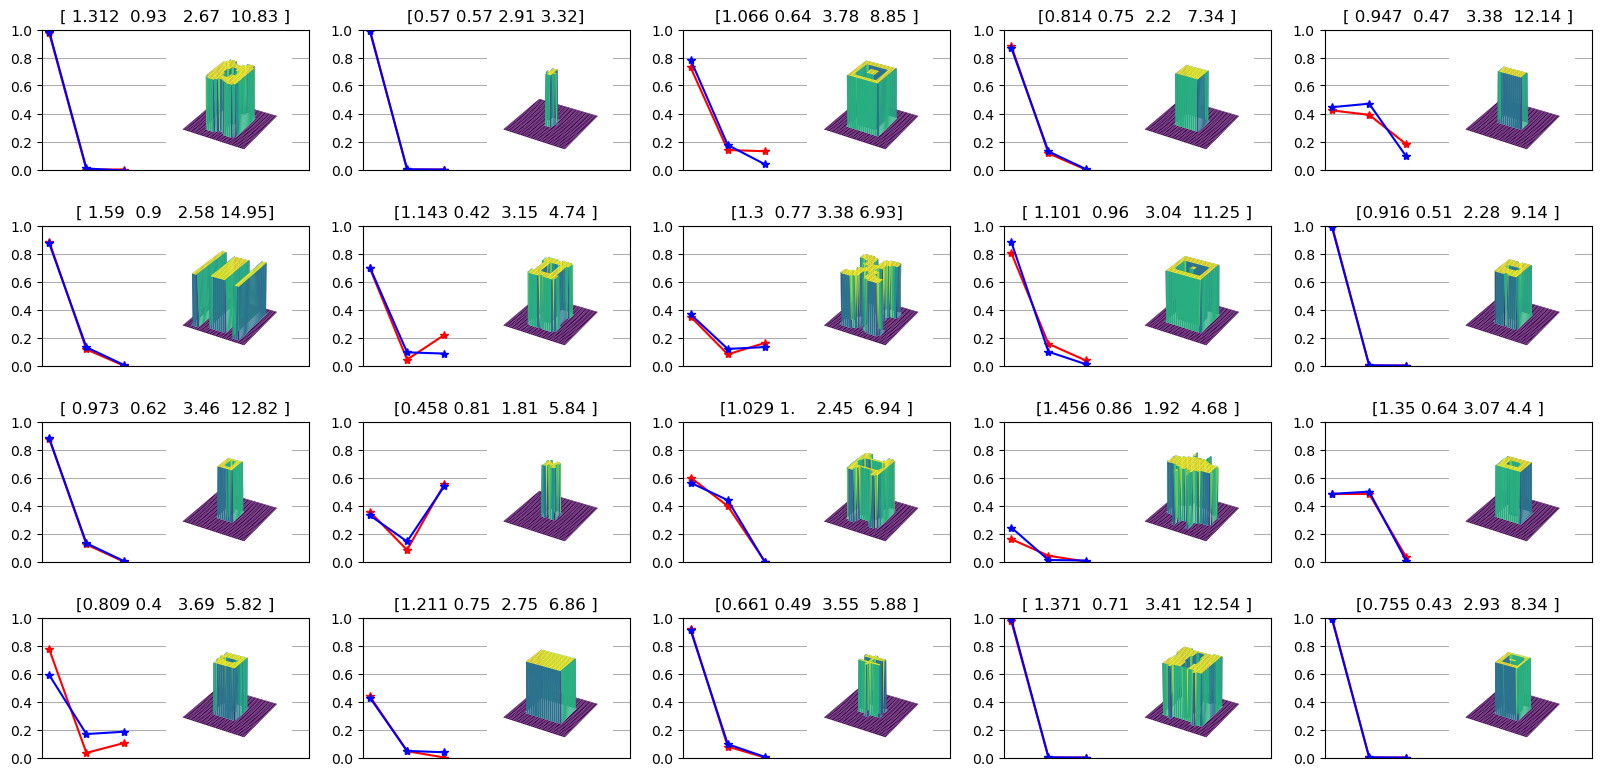

In [33]:
# plot results with 3D inset
# [Wavelength, lattice, n_atom, n_substrate]
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import random
import matplotlib.gridspec as gridspec

cases = 20
cols = 5
gs = gridspec.GridSpec(cases // cols + 1, cols)
gs.update(hspace=0.4)
fig = plt.figure(figsize = (20,12))
ax = []
test_number = []

for i in range(cases):
    number = np.random.randint(0, xs1.shape[0])
    test_number.append(number)
    row = i // cols
    col = i % cols

    # Existing plotting code
    ax = fig.add_subplot(gs[row, col])
    orig = ys1[number,:].to(device).cpu()
    pred = model_loaded(xs1[number, :].reshape(1, 4096).to(device), x1s1[number, :].reshape(1, 4).to(device)).cpu().detach().numpy()

    # Set up the plot for original data and prediction
    ax.plot(xaxis, orig, "r*-")
    ax.plot(xaxis, pred[0], "b*-")
    ax.grid(True)
    ax.set_xticks([])
    
    ax.set_title(x1s[number,0:4].detach().cpu().numpy())  # Your existing title setting code
    ax.set_ylim([0,1])
    ax.set_xlim([0.8,8])
    xaxis = np.linspace(1,3,3)

    # Create a 3D inset for the image
    axins = inset_axes(ax, width="90%", height="90%", loc='center', 
                       bbox_to_anchor=(0.2, 0, 1, 1),  # x, y, width, height
                       bbox_transform=ax.transAxes, axes_class=Axes3D)
    img_data = xs[number, :].cpu().numpy().reshape(64, 64)
    img_data = scale_pattern_in_binary_image(img_data, x1s[number, 0]/1.6)
    X, Y = np.meshgrid(np.arange(img_data.shape[0]), np.arange(img_data.shape[1]))
    Z = img_data

    # Disable visibility of the axes
    axins._axis3don = False
    axins.plot_surface(X, Y, Z, cmap='viridis')
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_zticks([])
plt.show()

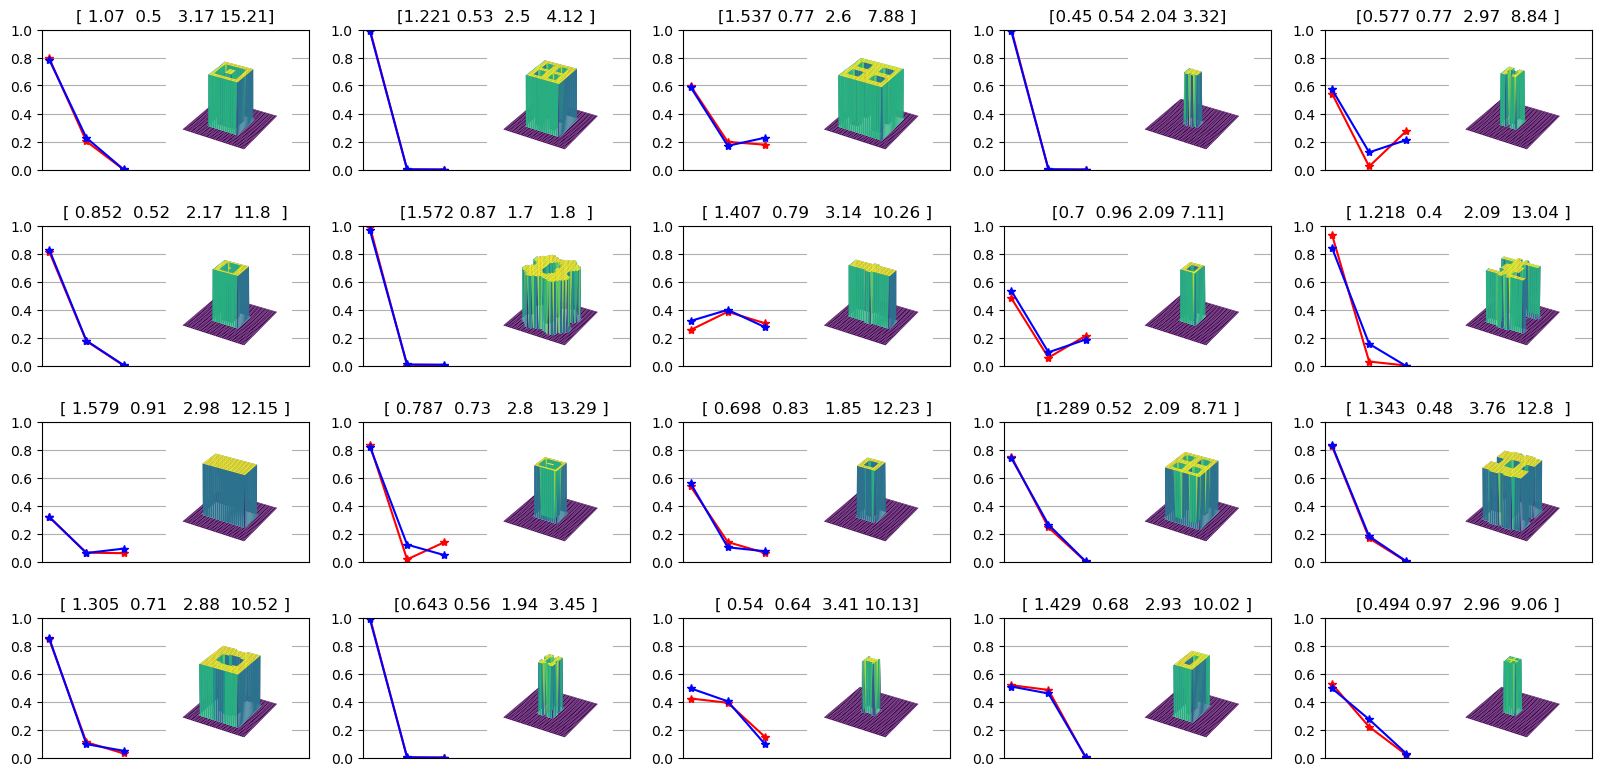

In [34]:
# plot results with 3D inset (train)
# [Wavelength, lattice, n_atom, n_substrate]
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import random
import matplotlib.gridspec as gridspec

cases = 20
cols = 5
gs = gridspec.GridSpec(cases // cols + 1, cols)
gs.update(hspace=0.4)
fig = plt.figure(figsize = (20,12))
ax = []
test_number = []

for i in range(cases):
    number = np.random.randint(0, xs.shape[0])
    test_number.append(number)
    row = i // cols
    col = i % cols

    # Existing plotting code
    ax = fig.add_subplot(gs[row, col])
    orig = ys[number,:].to(device).cpu()
    pred = model_loaded(xs[number, :].reshape(1, 4096).to(device), x1s[number, :].reshape(1, 4).to(device)).cpu().detach().numpy()

    # Set up the plot for original data and prediction
    ax.plot(xaxis, orig, "r*-")
    ax.plot(xaxis, pred[0], "b*-")
    ax.grid(True)
    ax.set_xticks([])
    
    ax.set_title(x1s[number,0:4].detach().cpu().numpy())  # Your existing title setting code
    ax.set_ylim([0,1])
    ax.set_xlim([0.8,8])
    xaxis = np.linspace(1,3,3)

    # Create a 3D inset for the image
    axins = inset_axes(ax, width="90%", height="90%", loc='center', 
                       bbox_to_anchor=(0.2, 0, 1, 1),  # x, y, width, height
                       bbox_transform=ax.transAxes, axes_class=Axes3D)
    img_data = xs[number, :].cpu().numpy().reshape(64, 64)
    img_data = scale_pattern_in_binary_image(img_data, x1s[number, 0]/1.6)
    X, Y = np.meshgrid(np.arange(img_data.shape[0]), np.arange(img_data.shape[1]))
    Z = img_data

    # Disable visibility of the axes
    axins._axis3don = False
    axins.plot_surface(X, Y, Z, cmap='viridis')
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_zticks([])
plt.show()

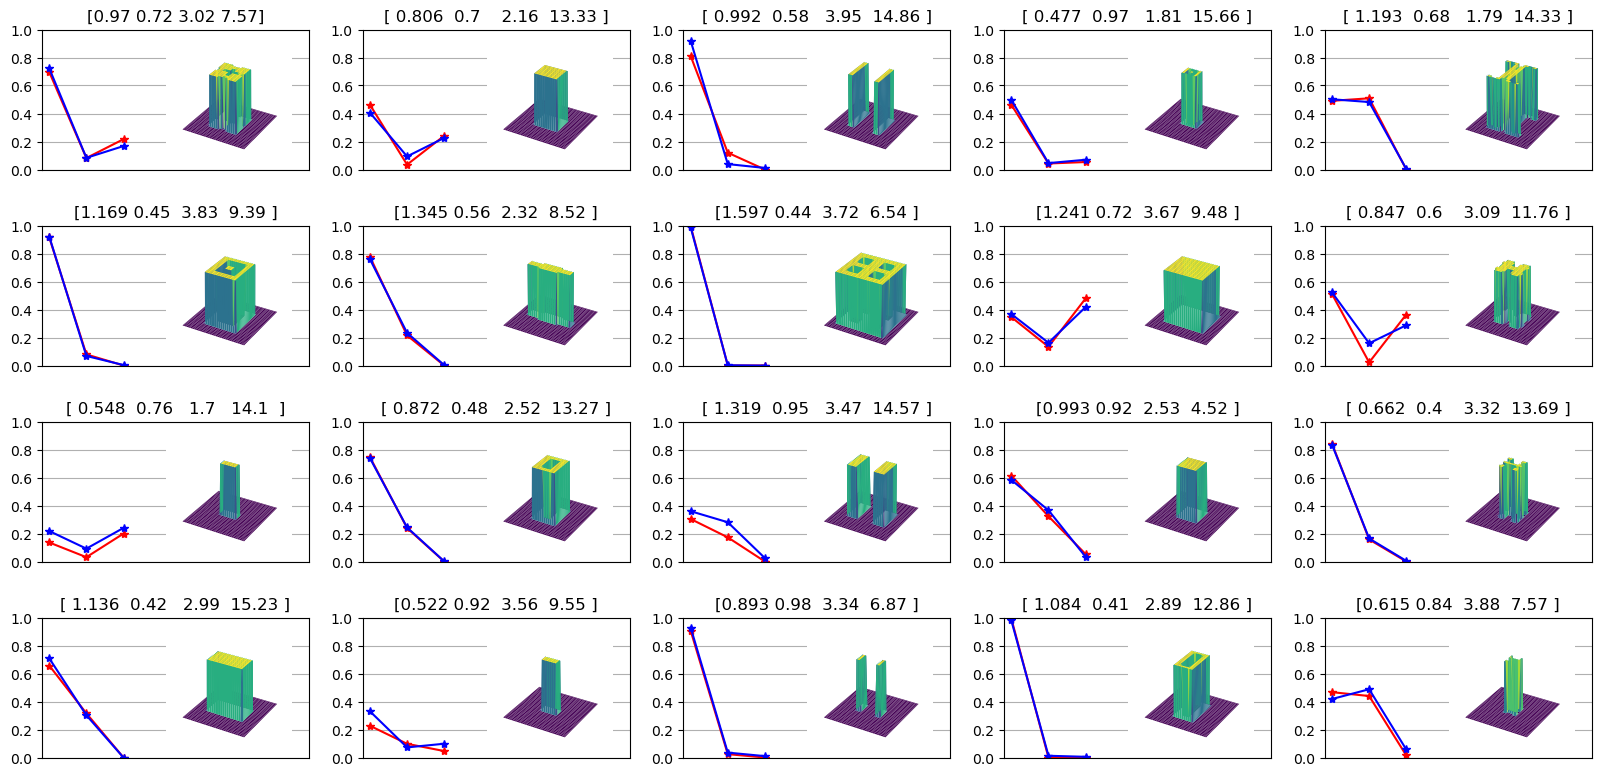

In [42]:
test_number = [602606,
 134767,
 679809,
 156869,
 949284,
 480906,
 842640,
 1019899,
 402229,
 224450,
 1072655,
 504738,
 608323,
 528478,
 1034584,
 484094,
 506476,
 17352,
 75245,
 204436]

# plot results with 3D inset (train)
# [Wavelength, lattice, n_atom, n_substrate]
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import random
import matplotlib.gridspec as gridspec

cases = 20
cols = 5
gs = gridspec.GridSpec(cases // cols + 1, cols)
gs.update(hspace=0.4)
fig = plt.figure(figsize = (20,12))
ax = []

for i in range(cases):
    number = test_number[i]
    row = i // cols
    col = i % cols

    # Existing plotting code
    ax = fig.add_subplot(gs[row, col])
    orig = ys[number,:].to(device).cpu()
    pred = model_loaded(xs[number, :].reshape(1, 4096).to(device), x1s[number, :].reshape(1, 4).to(device)).cpu().detach().numpy()

    # Set up the plot for original data and prediction
    ax.plot(xaxis, orig, "r*-")
    ax.plot(xaxis, pred[0], "b*-")
    ax.grid(True)
    ax.set_xticks([])
    
    ax.set_title(x1s[number,0:4].detach().cpu().numpy())  # Your existing title setting code
    ax.set_ylim([0,1])
    ax.set_xlim([0.8,8])
    xaxis = np.linspace(1,3,3)

    # Create a 3D inset for the image
    axins = inset_axes(ax, width="90%", height="90%", loc='center', 
                       bbox_to_anchor=(0.2, 0, 1, 1),  # x, y, width, height
                       bbox_transform=ax.transAxes, axes_class=Axes3D)
    img_data = xs[number, :].cpu().numpy().reshape(64, 64)
    img_data = scale_pattern_in_binary_image(img_data, x1s[number, 0]/1.6)
    X, Y = np.meshgrid(np.arange(img_data.shape[0]), np.arange(img_data.shape[1]))
    Z = img_data

    # Disable visibility of the axes
    axins._axis3don = False
    axins.plot_surface(X, Y, Z, cmap='viridis')
    axins.set_xticks([])
    axins.set_yticks([])
    axins.set_zticks([])
plt.show()